In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [24]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')

In [25]:
df.head()

,Ano,Lula_art,Lula_ind,Lula_art_ind,Lula_oceanica_art,Calamar_ind,Polvo_art,Polvo_ind,Polvo_art_ind,Polvo_cabecinha_art,...,Mexilhao_art,Mexilhao_ind,Mexilhao_mangue_art,Caramujo_art,Caramujo_ind,Vieira_ind,Berbigao_art,Vongole_art,TOTAL_MOLLUSCS,TOTAL_GROUPS_F&M
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28137.0
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27432.0
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26648.0
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24552.0
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22755.0


In [26]:
x0 = df[['Ano', 'Mexilhao_art']].dropna().values
x1 = df[['Ano', 'Mexilhao_ind']].dropna().values

In [27]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Mexilhao_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Mexilhao_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Mexilhao_art')
df_x1= df_x1.drop_duplicates(subset='Mexilhao_ind')

In [30]:
print(len(df_x1))

3


Normalização Dos dados

In [9]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Mexilhao_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [10]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

In [11]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

Epoch 100: loss = 0.3520600497722626
Epoch 200: loss = 0.36251381039619446
Epoch 300: loss = 0.33956271409988403
Epoch 400: loss = 0.3328593969345093
Epoch 500: loss = 0.33279770612716675
Epoch 600: loss = 0.336719274520874
Epoch 700: loss = 0.30304834246635437
Epoch 800: loss = 0.30957961082458496
Epoch 900: loss = 0.29995113611221313
Epoch 1000: loss = 0.2490757554769516
Epoch 1100: loss = 0.27092137932777405
Epoch 1200: loss = 0.24686679244041443
Epoch 1300: loss = 0.25566065311431885
Epoch 1400: loss = 0.2512800097465515
Epoch 1500: loss = 0.2476031333208084
Epoch 1600: loss = 0.24585974216461182
Epoch 1700: loss = 0.2618694007396698
Epoch 1800: loss = 0.24940118193626404
Epoch 1900: loss = 0.24196581542491913
Epoch 2000: loss = 0.25380852818489075
Epoch 2100: loss = 0.24534453451633453
Epoch 2200: loss = 0.26950907707214355
Epoch 2300: loss = 0.2456003576517105
Epoch 2400: loss = 0.24245426058769226
Epoch 2500: loss = 0.25839030742645264
Epoch 2600: loss = 0.24610422551631927
Epoc

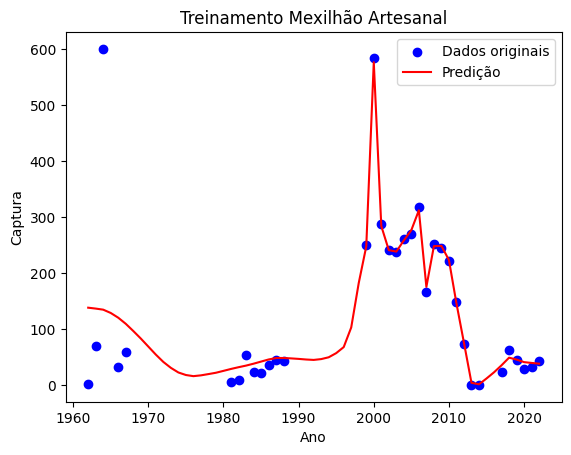

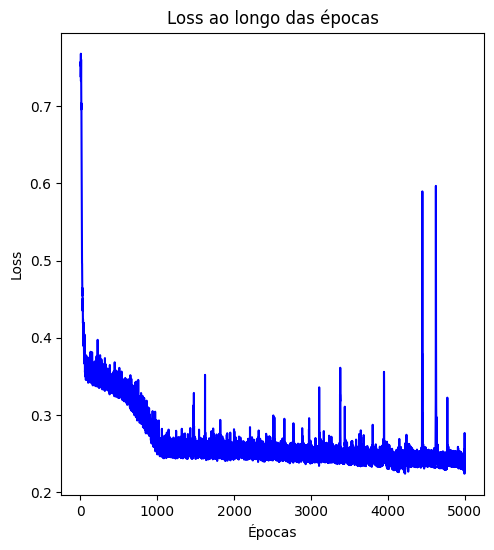

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Mexilhão Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predição para o ano 1965: 128.5850830078125
Predição para o ano 1968: 96.38920593261719
Predição para o ano 1969: 82.93623352050781
Predição para o ano 1970: 68.59239959716797
Predição para o ano 1971: 54.254478454589844
Predição para o ano 1972: 41.15204620361328
Predição para o ano 1973: 30.61663818359375
Predição para o ano 1974: 22.35352325439453
Predição para o ano 1975: 17.82501983642578
Predição para o ano 1976: 15.797065734863281
Predição para o ano 1977: 17.211090087890625
Predição para o ano 1978: 19.483291625976562
Predição para o ano 1979: 21.8773193359375
Predição para o ano 1980: 25.23413848876953
Predição para o ano 1990: 46.60102081298828
Predição para o ano 1991: 45.513214111328125
Predição para o ano 1992: 44.77307891845703
Predição para o ano 1993: 46.23358917236328
Predição para o ano 1994: 49.487815856933594
Predição para o ano 1995: 56.903564453125
Predição para o ano 1996: 67.67926025390625
Predição para o ano 1997: 102.75425

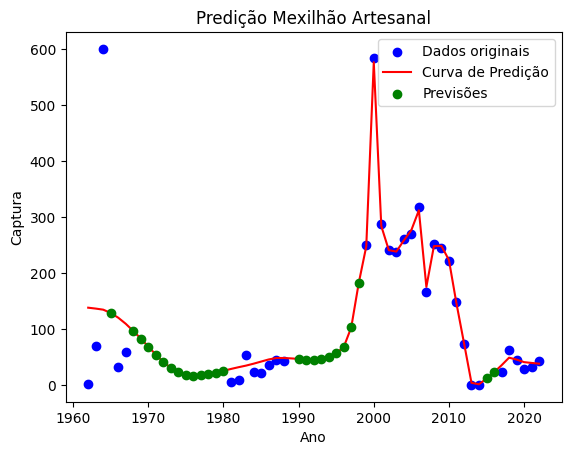

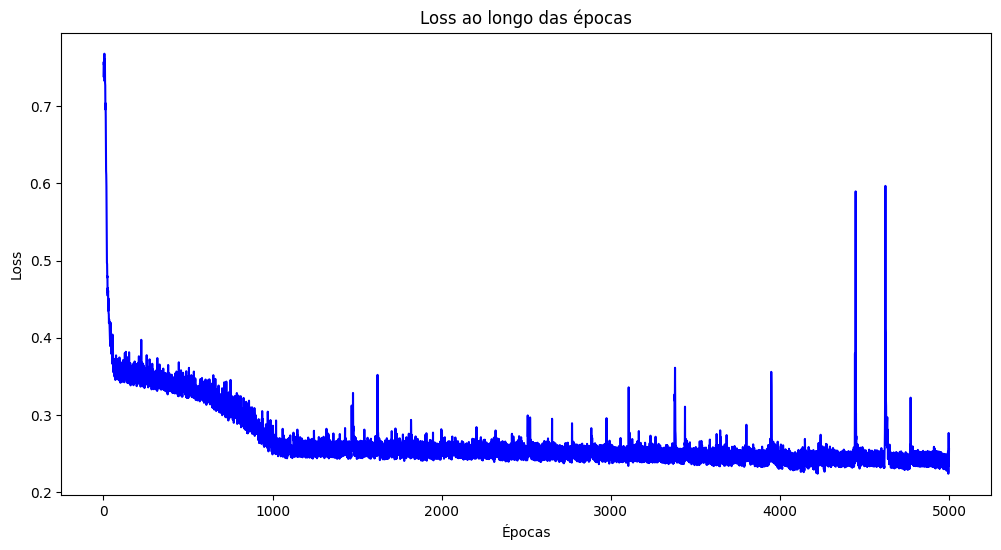

In [18]:

anos_para_prever = np.array([1965, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2015, 2016]).reshape(-1, 1)

anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std

predicoes_normalizadas = model.predict(anos_para_prever_normalizados)

predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Mexilhão Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


In [19]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('Mexilhão_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1962.0          2.000000               NaN
1   1963.0         70.000000               NaN
2   1964.0        600.000000               NaN
3   1965.0               NaN        128.585083
4   1966.0         32.000000               NaN
5   1967.0         59.000000               NaN
6   1968.0               NaN         96.389206
7   1969.0               NaN         82.936234
8   1970.0               NaN         68.592400
9   1971.0               NaN         54.254478
10  1972.0               NaN         41.152046
11  1973.0               NaN         30.616638
12  1974.0               NaN         22.353523
13  1975.0               NaN         17.825020
14  1976.0               NaN         15.797066
15  1977.0               NaN         17.211090
16  1978.0               NaN         19.483292
17  1979.0               NaN         21.877319
18  1980.0               NaN         25.234138
19  1981.0          5.000000               NaN
20  1982.0   

MEXILHÃO INDUSTRIAL

In [28]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Mexilhao_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 1.791199899514595e-08
Epoch 200: loss = 0.0016718009719625115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


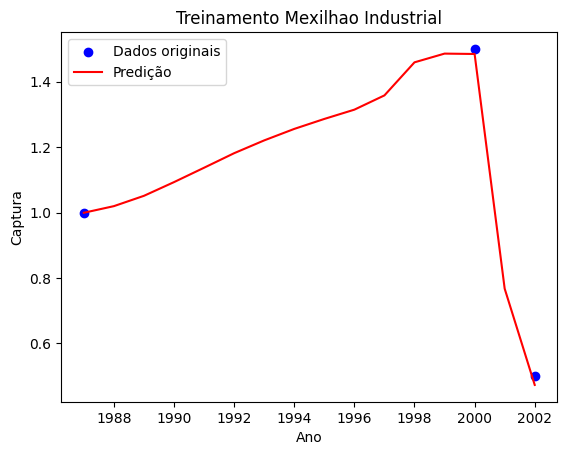

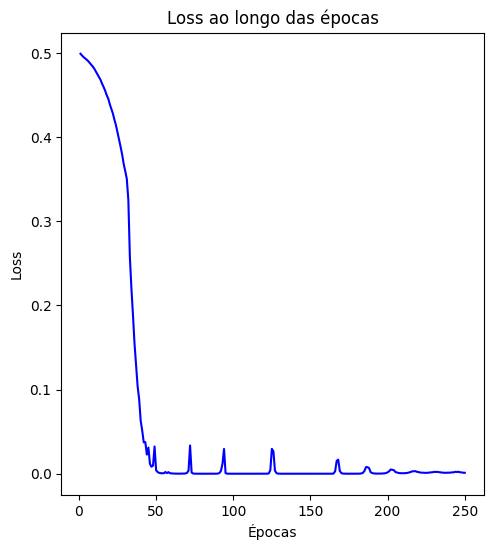

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=250, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Mexilhao Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predição para o ano 1990: 39.25775146484375
Predição para o ano 1991: 45.313636779785156
Predição para o ano 1992: 54.65289306640625
Predição para o ano 1993: 70.71717071533203
Predição para o ano 1994: 100.08758544921875
Predição para o ano 2016: 40.82793426513672


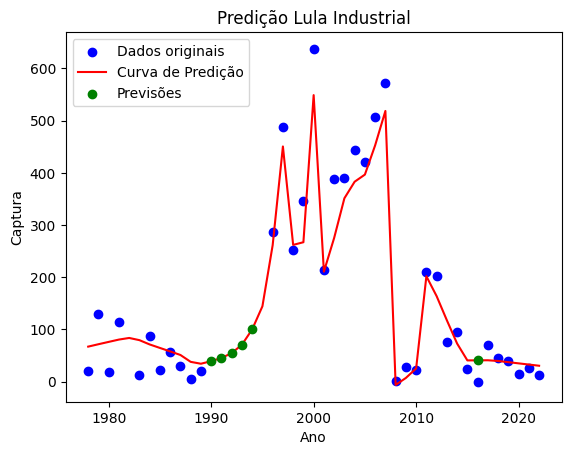

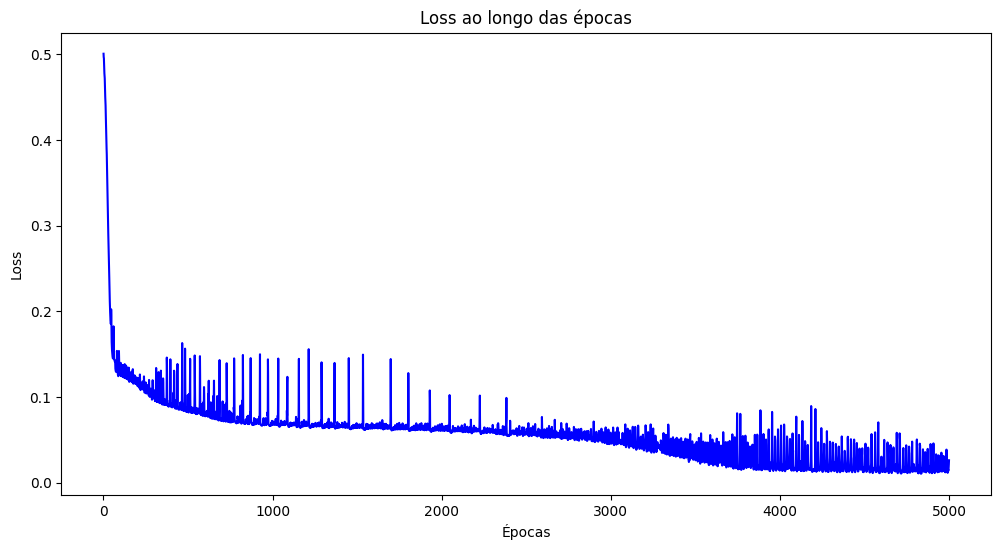

In [33]:
anos_para_prever = np.array([1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean

for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Lula Industrial')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [112]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('Lula_industrial_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1978.0         20.000000               NaN
1   1979.0        129.000000               NaN
2   1980.0         18.000000               NaN
3   1981.0        115.000000               NaN
4   1983.0         12.000000               NaN
5   1984.0         87.000000               NaN
6   1985.0         23.000000               NaN
7   1986.0         57.000000               NaN
8   1987.0         30.000000               NaN
9   1988.0          6.000000               NaN
10  1989.0         21.000000               NaN
11  1990.0               NaN          9.690598
12  1991.0               NaN         17.452179
13  1992.0               NaN         39.038246
14  1993.0               NaN         69.922310
15  1994.0               NaN        111.995232
16  1996.0        286.000000               NaN
17  1997.0        488.500000               NaN
18  1998.0        252.500000               NaN
19  1999.0        345.500000               NaN
20  2000.0   

LULA TOTAL

In [113]:
df_1 = pd.read_excel('DataFrame_reconstruido\Lula_artesanal_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Renan\AppData\Local\Temp\ipykernel_17812\249233856.py:1: SyntaxWarning: invalid escape sequence '\L'
  df_1 = pd.read_excel('DataFrame_reconstruido\Lula_artesanal_reconstruido.xlsx')


In [114]:
x0 = pd.DataFrame(df_1[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x1 = pd.DataFrame(df_1[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [117]:
resultado = x0['Captura Original'] + x1['Captura Preditos']

novo_df1 = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_art': resultado})

print(novo_df1)

     Ano    Lula_art
0   1978  106.000000
1   1979  175.000000
2   1980  335.000000
3   1981  373.000000
4   1982  127.000000
5   1983  140.000000
6   1984  209.000000
7   1985  176.000000
8   1986  114.000000
9   1987  198.000000
10  1988  112.000000
11  1989  146.000000
12  1990  188.263672
13  1991  235.988220
14  1992  288.477722
15  1993  338.323639
16  1994  377.022400
17  1995  389.500000
18  1996   36.500000
19  1997  104.000000
20  1998   12.500000
21  1999  127.500000
22  2000   14.000000
23  2001  184.500000
24  2002   88.500000
25  2003   86.500000
26  2004  101.000000
27  2005  106.500000
28  2006  122.500000
29  2007   72.500000
30  2008   17.559999
31  2009   34.530201
32  2010   10.680000
33  2011   20.593000
34  2012    8.878000
35  2013    9.596000
36  2014  209.839005
37  2015    2.517000
38  2016   48.941895
39  2017   56.960030
40  2018   33.903400
41  2019   41.963600
42  2020   29.422100
43  2021   56.820000
44  2022   63.434299


In [118]:
df_2 = pd.read_excel('DataFrame_reconstruido\Lula_industrial_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Renan\AppData\Local\Temp\ipykernel_17812\1443897365.py:1: SyntaxWarning: invalid escape sequence '\L'
  df_2 = pd.read_excel('DataFrame_reconstruido\Lula_industrial_reconstruido.xlsx')


In [119]:
x2 = pd.DataFrame(df_2[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x3 = pd.DataFrame(df_2[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [120]:
resultado_2 = x2['Captura Original'] + x3['Captura Preditos']

novo_df_2 = pd.DataFrame({'Ano': df_2['Ano'], 'Lula_ind': resultado_2})

print(novo_df_2)

     Ano    Lula_ind
0   1978   20.000000
1   1979  129.000000
2   1980   18.000000
3   1981  115.000000
4   1983   12.000000
5   1984   87.000000
6   1985   23.000000
7   1986   57.000000
8   1987   30.000000
9   1988    6.000000
10  1989   21.000000
11  1990    9.690598
12  1991   17.452179
13  1992   39.038246
14  1993   69.922310
15  1994  111.995232
16  1996  286.000000
17  1997  488.500000
18  1998  252.500000
19  1999  345.500000
20  2000  637.500000
21  2001  214.000000
22  2002  387.500000
23  2003  389.500000
24  2004  444.000000
25  2005  421.500000
26  2006  507.000000
27  2007  572.500000
28  2008    2.167000
29  2009   28.509001
30  2010   22.627001
31  2011  210.690994
32  2012  201.509995
33  2013   76.178001
34  2014   94.943001
35  2015   25.068001
36  2016   60.799649
37  2017   70.802971
38  2018   44.520100
39  2019   38.862202
40  2020   13.996800
41  2021   25.391800
42  2022   13.432000


In [132]:
resultado = x0['Captura Original'] + x1['Captura Preditos'] + x2['Captura Original'] + x3['Captura Preditos']

lula_total = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_total': resultado}).dropna()

print(lula_total)

     Ano  Lula_total
0   1978  126.000000
1   1979  304.000000
2   1980  353.000000
3   1981  488.000000
4   1982  139.000000
5   1983  227.000000
6   1984  232.000000
7   1985  233.000000
8   1986  144.000000
9   1987  204.000000
10  1988  133.000000
11  1989  155.690598
12  1990  205.715851
13  1991  275.026466
14  1992  358.400032
15  1993  450.318871
16  1994  663.022400
17  1995  878.000000
18  1996  289.000000
19  1997  449.500000
20  1998  650.000000
21  1999  341.500000
22  2000  401.500000
23  2001  574.000000
24  2002  532.500000
25  2003  508.000000
26  2004  608.000000
27  2005  679.000000
28  2006  124.667000
29  2007  101.009001
30  2008   40.187000
31  2009  245.221195
32  2010  212.189995
33  2011   96.771002
34  2012  103.821001
35  2013   34.664001
36  2014  270.638654
37  2015   73.319971
38  2016   93.461994
39  2017   95.822231
40  2018   47.900201
41  2019   67.355400
42  2020   42.854100


In [133]:
x = np.array(lula_total['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(lula_total['Lula_total'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

Epoch 1/1000


C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 142us/step - loss: 0.5091 - mse: 0.9983 
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.4965 - mse: 0.9736
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4811 - mse: 0.9434
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4654 - mse: 0.9125
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4513 - mse: 0.8849
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4378 - mse: 0.8584
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 0.4251 - mse: 0.8336
Epoch 8/1000
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8084 - mse: 0.8084

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4123 - mse: 0.8084
Epoch 9/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4011 - mse: 0.7864
Epoch 10/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.3920 - mse: 0.7686
Epoch 11/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.3833 - mse: 0.7516
Epoch 12/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.3752 - mse: 0.7356
Epoch 13/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.3631 - mse: 0.7119
Epoch 14/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.3525 - mse: 0.6912
Epoch 15/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.3416 - mse: 0.6698
Epoch 16/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.3278 - mse: 0.6428
Epoch 17/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.3154 - mse: 0.6184
Epoch 18/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.3008 - mse: 0.5898
Epoch 19/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.2851 - mse: 0.5591
Epoch 20/1000
50/50

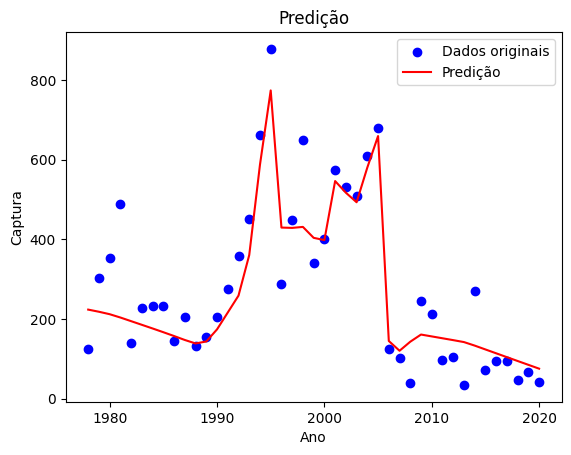

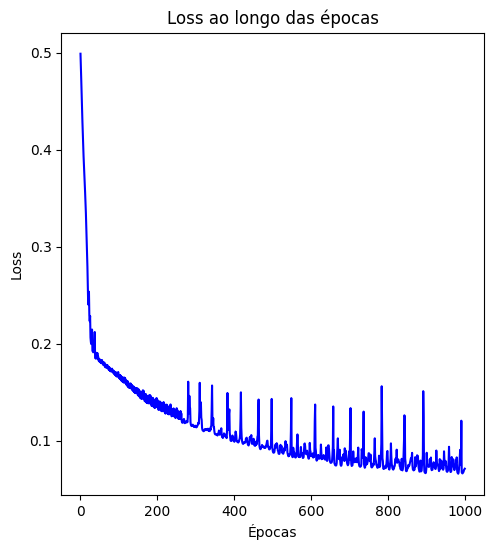

In [134]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Lula Artesanal e Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


In [1]:
df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='outer').sort_values(by='Ano')

# Adicionando as previsões específicas aos dados combinados
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')

# Plotando os dados originais e as previsões
plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões específicas', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

# Plotando a perda ao longo das épocas
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

NameError: name 'pd' is not defined